# Datafusion example

How to request Sentinel-1 and Sentinel-2 data over a given time period for all coinciding acquisitions.

Please note that `sentinelhub>=3.2.0` is required.

In [1]:
import json
import matplotlib.pyplot as plt
from sentinelhub import (SHConfig, BBox, CRS, SentinelHubRequest, DataCollection, MimeType, SentinelHubCatalog)

### Set up Sentinel Hub services credentials

In [2]:
# Set credentials
client_id = ""
client_secret = ""

In [3]:
# Set up credentials for use with Sentinel Hub python package
config = SHConfig()

if client_id and client_secret:
    config.sh_client_id = client_id
    config.sh_client_secret = client_secret
    
if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

### Set input parameters


In [4]:
# Set up AOI
rome = [12.44693, 41.870072, 12.541001, 41.917096]
rome_bbox = BBox(bbox=rome, crs=CRS.WGS84) 

In [5]:
# Time interval
time_interval = ('2020-10-27', '2021-01-14') 

### Catalog API request to fetch dates

In the following cells, we use the Catalog API (via the `sentinelhub-py` package) to query the acquisitions dates of both Sentinel-1 and Sentinel-2.

In [6]:
# Initialise the catalog class
catalog = SentinelHubCatalog(config=config)

In [7]:
# Query the S1 and S2 images based on the input parameters
# S1
s1_query = catalog.search(collection=DataCollection.SENTINEL1_IW, query={'resolution':{'eq':'HIGH'}},
                          time=time_interval, bbox=rome_bbox)
#S2
s2_query = catalog.search(collection=DataCollection.SENTINEL2_L1C, time=time_interval, bbox=rome_bbox)

In [8]:
# Print the parameters
print(f"Sentinel-1 input parameters:\n{s1_query.params}")
print("-" * 10)
print(f"Sentinel-2 input parameters:\n{s2_query.params}")

Sentinel-1 input parameters:
{'collections': ['sentinel-1-grd'], 'datetime': '2020-10-27T00:00:00Z/2021-01-14T23:59:59Z', 'bbox': [12.44693, 41.870072, 12.541001, 41.917096], 'query': {'resolution': {'eq': 'HIGH'}}, 'limit': 100}
----------
Sentinel-2 input parameters:
{'collections': ['sentinel-2-l1c'], 'datetime': '2020-10-27T00:00:00Z/2021-01-14T23:59:59Z', 'bbox': [12.44693, 41.870072, 12.541001, 41.917096], 'limit': 100}


#### Fetch Sentinel-1 and Sentiel-2 dates from the catalog query

For each catalog query, it is possible to extract the dates of the acquisitions.

In [9]:
s1_dates = [t.date() for t in s1_query.get_timestamps()]
s2_dates = [t.date() for t in s2_query.get_timestamps()]

#### List the common dates between the two datasets

In the next step, the common dates between the two sensors are saved to a list.

In [10]:
common_dates = [d.isoformat() for d in list(set(s1_dates).intersection(s2_dates))]
print(common_dates)

['2020-11-21', '2020-12-16', '2020-12-21']


### Run Sentinel Hub datafusion request on the common dates only

#### Build Evalscript

In the Evalscript, we specify the number of output bands according to the common dates in the time period (passed from the Python script to the Evalscript) as well as the array of allowed dates.

One output is created for each band. The output will contain data for each date that has a Sentinel-2 and a Sentinel-1 acquisition.


In [11]:
evalscript = f"""
//VERSION=3

// Get band numbers from common dates
var bandnum = {len(common_dates)};

// Get list of allowed dates
var allowedDates = {common_dates};

function setup() {{
  return {{
    input: [{{
        datasource: "S1GRD",
        bands: ["VV","VH"]
      }},
      {{
        datasource: "S2L2A",
        bands: ["B03"]
      }}
    ],
    // For each band create an output
    output: [
      {{
        id: "VV",
        bands: bandnum,
        sampleType: SampleType.FLOAT32
      }},
      {{
        id: "VH",
        bands: bandnum,
        sampleType: SampleType.FLOAT32
      }},
      {{
        id: "G",
        bands: bandnum,
        sampleType: SampleType.FLOAT32
      }},
    ],
    mosaicking: "ORBIT"
  }};
}}

// Filter for common dates
function preProcessScenes (collections) {{
    collections.S2L2A.scenes.orbits = collections.S2L2A.scenes.orbits.filter(function (orbit) {{
        var orbitDateFrom = orbit.dateFrom.split("T")[0];
        return allowedDates.includes(orbitDateFrom);
    }});
    collections.S1GRD.scenes.orbits = collections.S1GRD.scenes.orbits.filter(function (orbit) {{
        var orbitDateFrom = orbit.dateFrom.split("T")[0];
        return allowedDates.includes(orbitDateFrom);
    }});
    return collections;
}}

function evaluatePixel(samples) {{
  // Get Sentinel-1 and Sentinel-2 data
  var s1_data = samples.S1GRD;
  var s2_data = samples.S2L2A;
  
  // Initialise bands to be written
  var vv_band = [];
  var vh_band = [];
  var b3_band = [];

  // Add Sentinel-1 data to the band array
  for (i=0; i<s1_data.length;i++){{
    vv_band.push(s1_data[i].VV);
    vh_band.push(s1_data[i].VH);
  }}
  
  // Add Sentinel-2 data to the band array
  for (i=0; i<s2_data.length;i++){{
    b3_band.push(s2_data[i].B03);
  }}
  
  // Return one file per band containing data from all dates
  return {{
    VV: vv_band,
    VH: vh_band,
    G: b3_band
  }};
}}
"""

#### Build the request with `sentinelhub-py`

The outputs from the `evaluatePixel` function have to be specified as `responses` in the request. 

In [12]:
request = SentinelHubRequest(
    evalscript=evalscript,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL1_IW,
            time_interval=time_interval,
            other_args = {"dataFilter":{"resolution":"HIGH"},
                          "processing":{"backCoeff":"GAMMA0_TERRAIN",
                                        "orthorectify":True,
                                        "demInstance":"COPERNICUS"},
                          "id":"S1GRD"}
        ),
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L2A,
            time_interval=time_interval,
            other_args = {"id":"S2L2A"}
        ),
    ],
    responses=[
        SentinelHubRequest.output_response('VV', MimeType.TIFF),
        SentinelHubRequest.output_response('VH', MimeType.TIFF),
        SentinelHubRequest.output_response('G', MimeType.TIFF)
    ],
    bbox=rome_bbox,
    config=config,
    data_folder="./data_fusion/"
)

#### Run the request and download the images

In [13]:
all_common_data = request.get_data(save_data=True)

#### Plot an example 

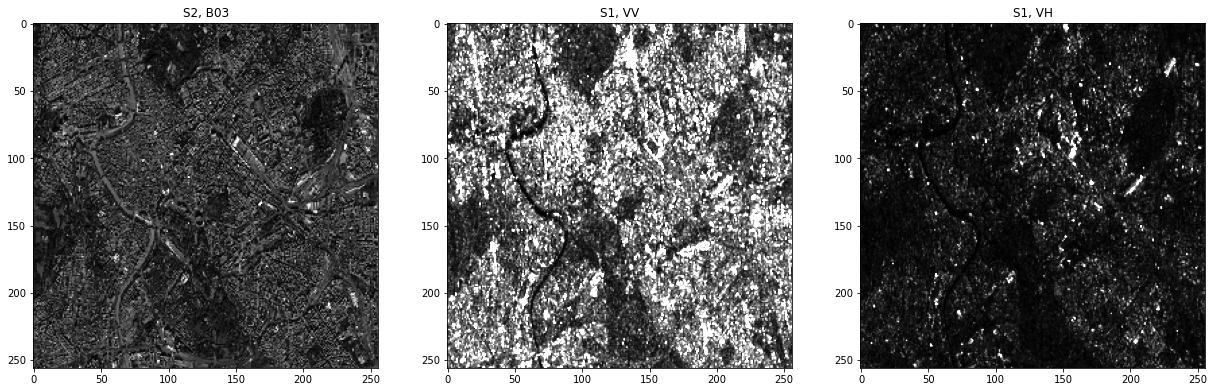

In [14]:
fig, ax = plt.subplots(ncols=3, figsize=(21,7))

# Plot first date of the three bands
ax[0].imshow(all_common_data[0]["G.tif"][:,:,1]*2.5, vmin=0, vmax=1, cmap="Greys_r")
ax[1].imshow(all_common_data[0]["VV.tif"][:,:,1], vmin=0, vmax=1, cmap="Greys_r")
ax[2].imshow(all_common_data[0]["VH.tif"][:,:,1], vmin=0, vmax=1, cmap="Greys_r")

ax[0].set_title("S2, B03")
ax[1].set_title("S1, VV")
ax[2].set_title("S1, VH")

plt.show()